# Model Comparison

In this example you will learn how to compare different models with TruLens.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/truera/trulens/blob/main/trulens_eval/examples/expositional/models/multimodal_eval.ipynb)

## Setup
### Add API keys
For this quickstart you will need Open AI and Huggingface keys

In [1]:
from IPython.display import Image
import io
import requests

import os
os.environ["REPLICATE_API_TOKEN"] = "..."

In [2]:
import replicate

def image_generator(prompt):
    output = replicate.run(
  "stability-ai/stable-diffusion:27b93a2413e7f36cd83da926f3656280b2931564ff050bf9575f1fdf9bcd7478",
  input={"prompt": prompt}
)
    return output[0]

In [3]:
image = image_generator("An iguana on the beach, pointilism")

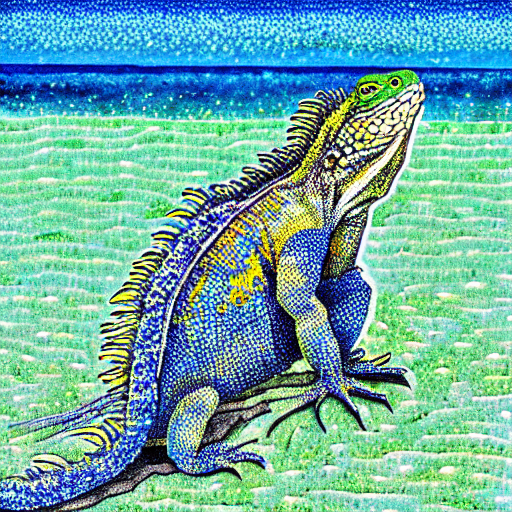

In [4]:
Image(image)

In [5]:
from trulens_eval import Replicate
from pydantic import BaseModel, Field

import json

In [79]:
class Multimodal(Replicate):
    model_engine: str = "yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591"

    def __init__(self, model_engine: str = model_engine):
        super().__init__()
        self.model_engine = model_engine

    def _handle_streaming(self, output) -> str:
        full_output = []
        for item in output:
            print(item, end="")
            full_output.append(item)
        # Join the list of strings into a single string
        output_str = ''.join(full_output)
        # Replace single quotes with double quotes
        output_str = output_str.replace("'", '"')
        return output_str  # Add this line

    def _eval_image(self, image_url: str, eval_prompt: str) -> dict:
        response = requests.get(image_url)
        file_bytes = response.content

        file_like_object = io.BytesIO(file_bytes)

        output = replicate.run(
            self.model_engine,
            input={"image": file_like_object, "prompt" : eval_prompt}
        )
        output_str = self._handle_streaming(output)
        
        return json.loads(output_str)

    def iguana_score(self, image_url: str) -> float:
        eval_prompt = eval_prompt = "Is the image of an iguana? Rate from 0 to 10 and respond only with the rating as a float."
        score = self._eval_image(image_url = image_url, eval_prompt = eval_prompt)
        return float(score)

    def pointilism_score(self, image_url: str) -> float:
        eval_prompt = "Is the image in pointilism style? Rate from 0 to 10 and respond only with the rating as a float."
        score = self._eval_image(image_url = image_url, eval_prompt = eval_prompt)
        return float(score)

In [80]:
Tru().reset_database()

Deleted 6 rows.


In [81]:
lmm = Multimodal()

In [82]:
from trulens_eval import Feedback
f_iguana_score = Feedback(lmm.iguana_score).on_output()
f_pointilism_score = Feedback(lmm.pointilism_score).on_output()

feedbacks = [f_iguana_score, f_pointilism_score]

✅ In iguana_score, input image_url will be set to *.__record__.main_output or `Select.RecordOutput` .
✅ In pointilism_score, input image_url will be set to *.__record__.main_output or `Select.RecordOutput` .


In [83]:
from trulens_eval import TruBasicApp

tru_multimodal_recorder = TruBasicApp(image_generator, app_id="Image Generator", feedbacks=feedbacks)

In [84]:
with tru_multimodal_recorder as recording:
    tru_multimodal_recorder.app("An iguana on the beach, pointilism")

7.58.5

In [11]:
from trulens_eval import Tru

Tru().run_dashboard()

Starting dashboard ...
Config file already exists. Skipping writing process.
Credentials file already exists. Skipping writing process.


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://192.168.4.23:8503 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

{'Score': 8, 'reason': {'reason': 'The image is a lizard, possibly an iguana, standing on the sand. The lizard has a long tail and is looking up. The color of the lizard is green, which is a common color for iguanas. The lizard's posture and appearance are consistent with that of an iguana. However, without more specific details, it is not possible to definitively confirm whether it is an iguana or not. The image is a painting, which may add to the difficulty of identifying the exact species of the lizard. '}}

Feedback function iguana_score with aggregation <function mean at 0x114c21440> had no inputs.


Evaluation of iguana_score failed on inputs: 
{'image_url': 'https://pbxt.replicate.delivery/Yf0Ob4N2fikBMULWBNWj4P8iFb6g9YCus7pQo1s4HrfTgjfGB/out-0.png'}
Expecting ',' delimiter: line 1 column 229 (char 228).
Yes, the image is in pointilism style. The score is 9, as the image features a lizard on a beach with a blue sky in the background, which are both elements of pointilism. The lizard is also depicted in a stylized manner, with its body and tail being the main focus of the image. The reason for the score of 9 is that the image captures the essence of pointilism, but the lizard's features are not as detailed as they could be to achieve a perfect score of 10.

Feedback function pointilism_score with aggregation <function mean at 0x114c21440> had no inputs.


Evaluation of pointilism_score failed on inputs: 
{'image_url': 'https://pbxt.replicate.delivery/Yf0Ob4N2fikBMULWBNWj4P8iFb6g9YCus7pQo1s4HrfTgjfGB/out-0.png'}
Expecting value: line 1 column 1 (char 0).


In [41]:
import json
json_string = "{'Score': 8, 'reason': {'reason': 'The image is a lizard, possibly an iguana, standing on the sand. The lizard has a long tail and is looking up. The color of the lizard is green, which is a common color for iguanas. The lizard's posture and appearance are consistent with that of an iguana. However, without more specific details, it is not possible to definitively confirm whether it is an iguana or not. The image is a painting, which may add to the difficulty of identifying the exact species of the lizard. '}}"

def is_valid_json(json_string):
    try:
        json.loads(json_string)
        return True
    except ValueError:
        return False

In [42]:
is_valid_json(json_string)

False